In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline


In [50]:
from transformers import (
    GPT2Config,
    GPT2Tokenizer,
    GPT2LMHeadModel,
)

In [51]:
modelname = '../models/pretrained/gpt2-large/'
config = GPT2Config.from_pretrained(modelname)
tokenizer = GPT2Tokenizer.from_pretrained(modelname)

In [52]:
import sys
sys.path.append('../')
from rl_learner import TD_Learner
import torch
import pickle
device = 'cpu'
import sys
sys.path.append('../')

from cvar_helpers import calc_cvar_from_samples
from train_rl_batch_sentence_chains import average_states_by_period

### Mscl

In [66]:

from difflib import SequenceMatcher

In [67]:
SequenceMatcher(None,'I will leave the house.', 'I will leave a house.').ratio()

0.9090909090909091

In [47]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('../models/pretrained/nli-distilroberta-base')
scores = model.predict([('A man is eating pizza', 'A man eats something'), 
                        ('A black race car starts up in front of a crowd of people.', 'A man is driving down a lonely road.'),
                        ('')])

#Convert scores to labels
label_mapping = ['contradiction', 'entailment', 'neutral']
labels = [label_mapping[score_max] for score_max in scores.argmax(axis=1)]

In [48]:
scores

array([[-3.472937  ,  3.7184172 ,  0.30496487],
       [ 4.732199  , -3.2566082 , -2.0175314 ]], dtype=float32)

### Loading Training Data 

In [53]:
file = '../data/results/sentence_chains_I_2/generations.txt'
f = open(file, "r")
sentences = f.readlines()
sentences = [s.replace('\n','') for s in sentences]
sentences = [s.split('r_all=')[0] for s in sentences]
state_rewards =  [np.array(s.split('r=')[-1].split(',')).astype('float') for s in sentences]

In [61]:
# removing some bad examples #
state_rewards2 = []
sentences2 = []
for r,s in zip(state_rewards, sentences):
    if len(r)!=3:
        pass
    else:
        state_rewards2.append(r)
        sentences2.append(s)
sentences = sentences2
state_rewards = np.array(state_rewards2)

# choose rewards 
summed_rewards = state_rewards.sum(axis=1)
final_rewards = state_rewards[:,-1]

assert len(sentences) == len(final_rewards)

In [8]:
#np.array(state_rewards)

In [62]:
len(sentences)
len(final_rewards)

1000

In [63]:
print(sentences[0:5])
print(final_rewards[0:5])
print(state_rewards[0:5])

['Tomorrow I will wake up early. I will leave the house. I will do not a thing. I have no time to talk to you. I am sure that you know that I have no time to talk to you. p=0.084,0.11,0.244 r=-0.604,-0.826,-0.635 ', 'Tomorrow I will wake up early. I will leave the house. I will walk out of the house. I will not return to this house. Let me take off my clothes. p=0.207,0.16,0.085 r=-0.112,-0.864,-0.1 ', 'Tomorrow I will wake up early. I will leave the house. I will walk out of the house. I will leave the house and go my own way. You will not find me. p=0.173,0.139,0.106 r=-0.112,0.083,-0.412 ', 'Tomorrow I will wake up early. I will leave the house. My inner monologue will circulate rapidly. I will wake up. I will leave. p=0.091,0.155,0.108 r=0.138,0.324,-0.23 ', 'Tomorrow I will wake up early. I will leave the house. I will leave my room. I will jump in the car. I will drive on the freeway. p=0.178,0.112,0.108 r=-0.165,0.072,-0.036 ']
[-0.635 -0.1   -0.412 -0.23  -0.036]
[[-0.604 -0.82

Text(0.5, 1.0, 'final reward')

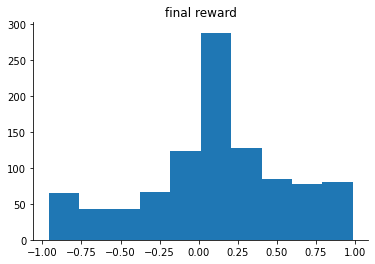

In [64]:
plt.hist(final_rewards)
sns.despine()
plt.title('final reward')

Text(0.5, 1.0, 'summed reward')

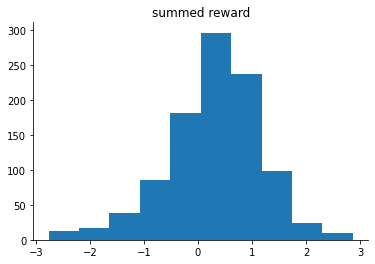

In [65]:
plt.hist(summed_rewards)
sns.despine()
plt.title('summed reward')

### Print some Negative Examples

In [68]:
sort_idx = np.argsort(final_rewards)
for s in np.array(sentences)[sort_idx][0:20]:
    print(s)
    print()

Tomorrow I will wake up early. I will leave the house. I will walk around the market. The only thing I will talk about is your mother. Your mother, I will never forgive her. p=0.135,0.078,0.097 r=0.132,-0.048,-0.961 

Tomorrow I will wake up early. I will leave the house. I will go to the Swayze Center. I will find you. I am just too tired. p=0.099,0.084,0.084 r=0.33,0.252,-0.951 

Tomorrow I will wake up early. I will leave the house. I will come out. I will not look inside. I will not listen to the noise outside. p=0.171,0.152,0.094 r=0.289,-0.493,-0.945 

Tomorrow I will wake up early. I will leave the house. I will go on a picnic with my girlfriend. I will do something really stupid and I will not get caught, but maybe I will succeed. Why does it bother me, why does it bother me, I don't know. p=0.083,0.072,0.105 r=0.619,-0.373,-0.942 

Tomorrow I will wake up early. I will leave the house. I will start working. I will leave. I will never see you again. p=0.147,0.16,0.131 r=0.223,-

In [70]:
sort_idx = np.argsort(summed_rewards)
for s in np.array(sentences)[sort_idx][-20:]:
    print(s)
    print()

Tomorrow I will wake up early. I will leave the house. I will cook a delicious meal. I will go for a run. My life will return to normal. p=0.078,0.083,0.127 r=0.936,0.297,0.704 

Tomorrow I will wake up early. I will leave the house. I will go to sleep early, and I will come back early. I will have a better time. I will be more productive. p=0.201,0.097,0.109 r=0.271,0.861,0.828 

Tomorrow I will wake up early. I will leave the house. I will leave here in the morning… am jovial. I'm happy. This is wonderful, — I thought he was going to say some nonsense. p=0.109,0.135,0.099 r=0.642,0.973,0.395 

Tomorrow I will wake up early. I will leave the house. I will leave all my worries behind me. I will love you always. I will be your perfect little girl. p=0.169,0.101,0.102 r=0.288,0.918,0.867 

Tomorrow I will wake up early. I will leave the house. I will go to the mall. I will buy myself a nice car. I will feel good about myself, and I will drink, to sleep and to smile. p=0.13,0.079,0.096 r=

### Print some Positive Examples

In [69]:
sort_idx = np.argsort(final_rewards)
for s in np.array(sentences)[sort_idx][-20:]:
    print(s)
    print()

Tomorrow I will wake up early. I will leave the house. I will be together with you. I will not leave you. I will have a long night and happy dream. p=0.08,0.091,0.182 r=0.743,0.162,0.956 

Tomorrow I will wake up early. I will leave the house. I will go to a party. My friends will get together. We will have fun and share silly stories. p=0.097,0.094,0.079 r=0.461,0.492,0.957 

Tomorrow I will wake up early. I will leave the house. I will go out and just have a life. And I'll do everything I can to be happy for the rest of my life. I love you. p=0.076,0.126,0.147 r=0.235,0.953,0.958 

Tomorrow I will wake up early. I will leave the house. I will be great. Life is, like, a walk of shame. I am great. p=0.099,0.146,0.102 r=0.916,-0.949,0.963 

Tomorrow I will wake up early. I will leave the house. It will be tomorrow at noon. Here I am. I feel good. p=0.081,0.099,0.108 r=0.079,-0.032,0.965 

Tomorrow I will wake up early. I will leave the house. I will go to my room and drop off the garbag

### Load the Quantile Learner

In [80]:
epoch=80
hidden_dim =100
n_quantiles = 10
prompt_enc = ''
filename='../data/results/sentence_chains_I_2/'
filename+=f'quantile_learner_{hidden_dim}_0.1{prompt_enc}/log_quantile_learner_epoch{epoch}.pkl'

Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)
Z_network.load_state_dict(torch.load(filename.replace('log_',''),map_location=torch.device('cpu')))

log = pickle.load(open(filename,'rb'))
loss = np.array(log['loss'])
epoch = np.array(log['epoch'])

### Training Loss

Text(0.5, 0, 'epochs')

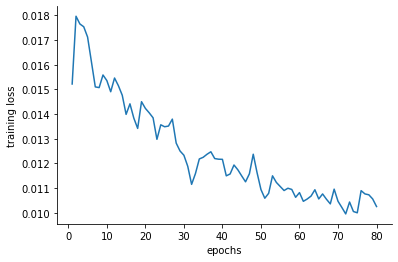

In [81]:
plt.plot(epoch, loss)
sns.despine()
plt.ylabel('training loss')
plt.xlabel('epochs')

### Stored Examples 

- for 100, I was not storing the examples correctly

In [82]:
examples = ['I puked all over my living room floor and waited.',
                        "You're dirty.",
                        'I took the stupid potty training class and passed out on the mat.',
                        'My knuckles are tired.',
                        'I got on a park bench and happily listened to Mozart and Praxis performed.',
                        'I was, of course, all six packer eyes.',
                        "That was his New Year's Resolution: health.",
                        "It was very nice.",
                        "The benefits of moving early always seem pretty obvious to me.",
                        "The sun was shining and I'd made it to campus on time."]

In [83]:
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
taus

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

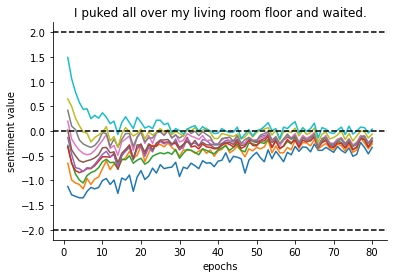

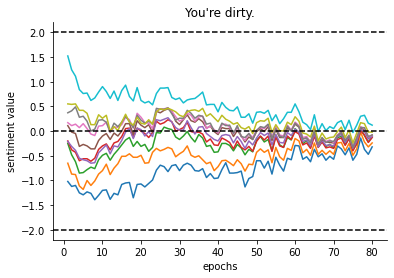

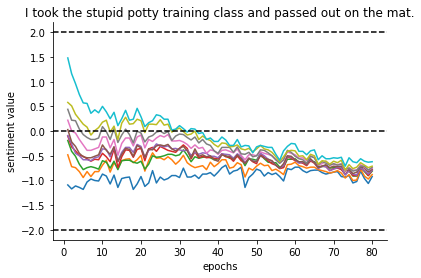

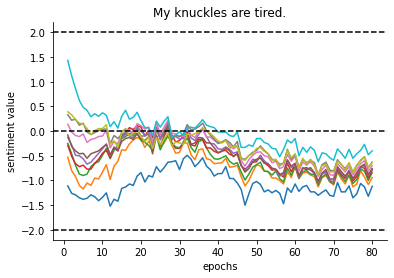

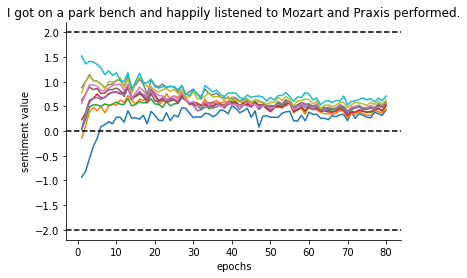

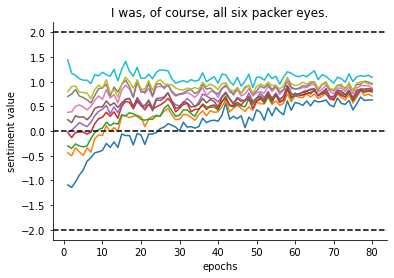

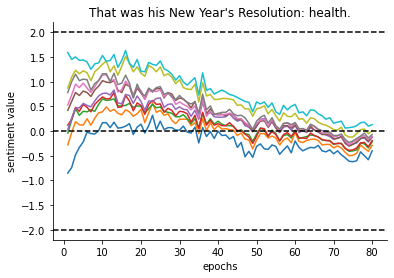

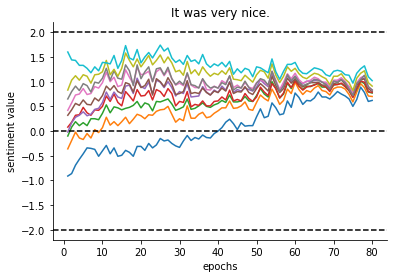

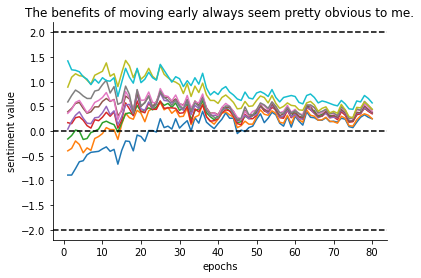

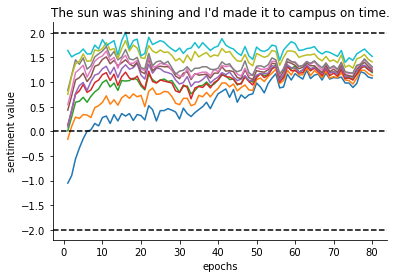

In [84]:
for example in examples:
    
    if example in log.keys():
        plt.figure()
        plt.plot(epoch, np.array(log[example]))
        sns.despine()
        plt.axhline(y=-2, color='k', linestyle='--')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.axhline(y=2, color='k', linestyle='--')
        plt.ylabel('sentiment value')
        plt.xlabel('epochs')
        plt.title(example)

        sel = np.array([example in s for s in sentences]).astype('bool')
        if np.sum(sel)>0:
            thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
            print(thetas)
            for theta in thetas:
                    plt.axhline(y=theta, linestyle='--', color='k', linewidth=0.5)

### Examples from training set

In [85]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

In [86]:
examples = ['I puked all over my living room floor and waited.',
                        "You're dirty.",
                        'I took the stupid potty training class and passed out on the mat.',
                        'My knuckles are tired.',
                        'I got on a park bench and happily listened to Mozart and Praxis performed.',
                        'I was, of course, all six packer eyes.',
                        "That was his New Year's Resolution: health.",
                        "It was very nice.",
                        "The benefits of moving early always seem pretty obvious to me.",
                        "The sun was shining and I'd made it to campus on time.",
           'I got dressed.',
           'I took my shower.',
           'I went to the bathroom.']

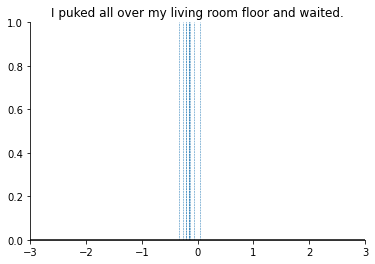

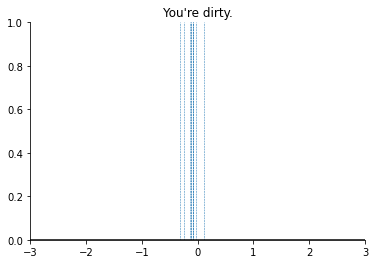

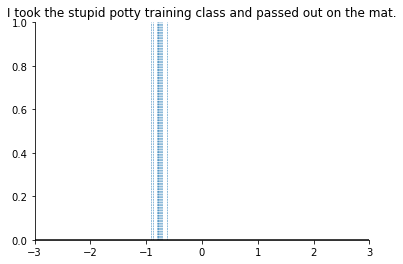

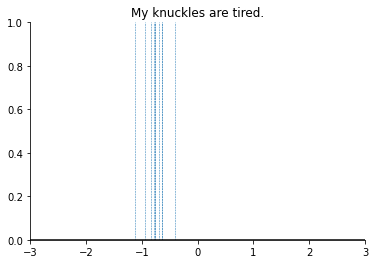

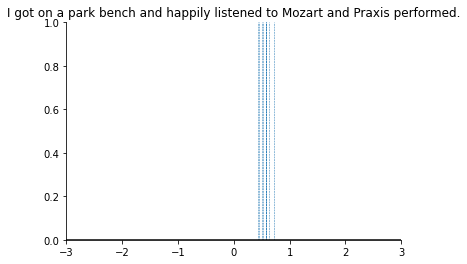

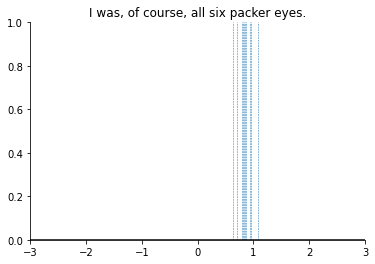

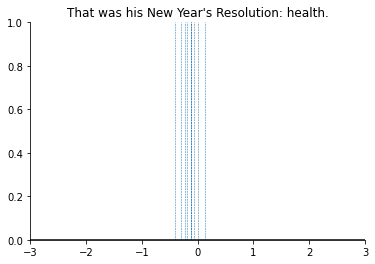

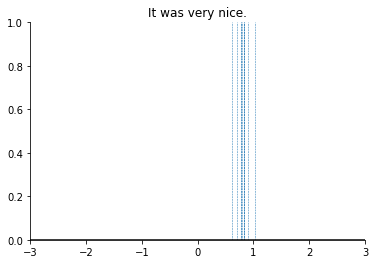

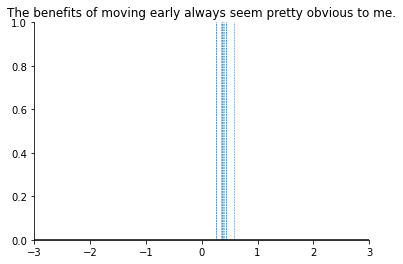

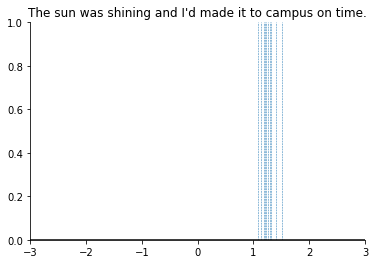

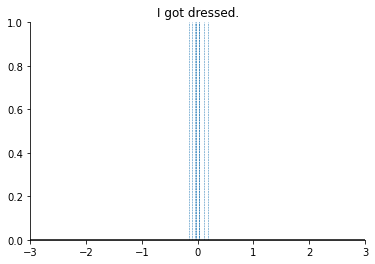

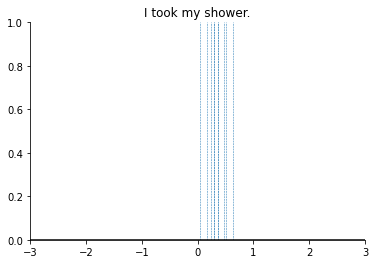

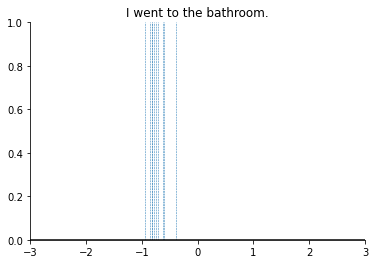

In [87]:
for example in examples:
    
    inputs = tokenizer(example, return_tensors='pt').to(device)
    with torch.no_grad():
        input_ids = inputs['input_ids']
        mask = inputs['attention_mask']
        output = model(input_ids=input_ids,
                       attention_mask=mask,
                       output_hidden_states=True)
        states = output['hidden_states'][-1]
        states, _ = average_states_by_period(states, mask.unsqueeze(-1), input_ids, device,
                                            n_periods=example.count('.'), period_tok_id=13, pad_tok_id=50256)
        
        theta_hats = Z_network(states).detach().cpu().numpy().round(2)
        theta_hats_last = theta_hats[:,-1,:].squeeze()
    #print(theta_hats_last)

    plt.figure()
    
    for theta in theta_hats_last:
        plt.axvline(x=theta, linestyle='--', linewidth=0.5)

    sel = np.array([example in s for s in sentences]).astype('bool')
    if np.sum(sel)>0:
        thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
        for theta in thetas:
            plt.axvline(x=theta, ymax=0.5, linestyle='--', linewidth=0.5, color='k')

    plt.xlim([-3,3])
    plt.axhline(y=0., color='k')
    sns.despine()
    plt.title(example)

### Plotting Distributions

In [89]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05]
top_k =10
prompt_enc = ''
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_2/generations_{alpha}.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


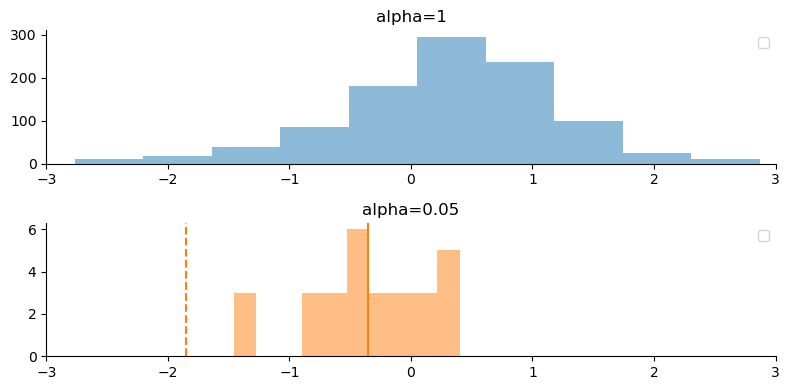

In [91]:

# full distribution
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(summed_rewards[sel], alpha=0.5, label=f'{stem}', density=False)

plt.legend()
sns.despine()
plt.xlim([-3,3])
plt.title(f'alpha=1')

# alphas 
for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    _, cvar = calc_cvar_from_samples(summed_rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-3,3])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

### Printing Examples

In [92]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [93]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
rewards_storage = {}
cvar_storage = {}
quantile_storage = {}
top_k=10

for alpha in [0.05]:

    file = f'../data/results/sentence_chains_I_2/cvar_output_{alpha}.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alpha_storage']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences_storage']
    rewards_storage[alpha] = loaded['rewards_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']

FileNotFoundError: [Errno 2] No such file or directory: '../data/results/sentence_chains_I_2/cvar_output_0.05.pkl'

In [94]:
alpha =0.05
for s, (sentence,r) in enumerate(zip(sentences_storage[alpha], rewards_storage[alpha])):
    if sentence not in sentences:
        print(s, sentence, np.round(r,2), np.round(np.sum(r),2))
        print()

KeyError: 0.05